In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, Input, Lambda, Layer, LSTM, MaxPooling2D, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import tensorflow as tf

import sys
sys.path.append(os.path.abspath('../..'))
from text_recognizer.datasets.iam_paragraphs import IamParagraphsDataset
import utils as utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
dataset = IamParagraphsDataset(downsample_factor=2)
dataset.load_or_generate_data()
print(dataset)

Loading IAM paragraph crops and ground truth from image files...
IAM Paragraphs Dataset
Num classes: 3
Train: (1229, 256, 256, 1) (1229, 256, 256, 3)
Test: (308, 256, 256, 1) (308, 256, 256, 3)



In [3]:
def plot(image):
    plt.figure(figsize=(15, 15))
    plt.imshow(image[:,:,0], cmap='gray', vmin=0, vmax=max(1, image.max()))
    plt.colorbar()

def hplot(x, y, y_pred=None, title=''):
    fig = plt.figure(figsize=(16, 9))
    fig.suptitle(title)
    
    ax1 = fig.add_subplot(131)
    ax1.imshow(x[:,:,0], cmap='gray', vmin=0, vmax=max(1, x.max()))
    
    ax2 = fig.add_subplot(132)
    ax2.imshow(y.reshape(x.shape)[:,:,0], cmap='gray', vmin=0, vmax=max(1, y.max()))
    
    if y_pred is not None:
        ax3 = fig.add_subplot(133)
        ax3.imshow(y_pred.reshape(x.shape)[:,:,0], cmap='gray', vmin=0, vmax=max(1, y_pred.max()))

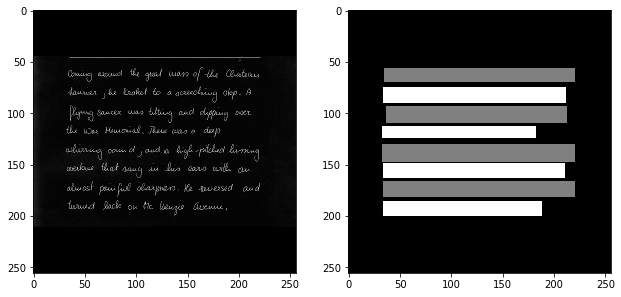

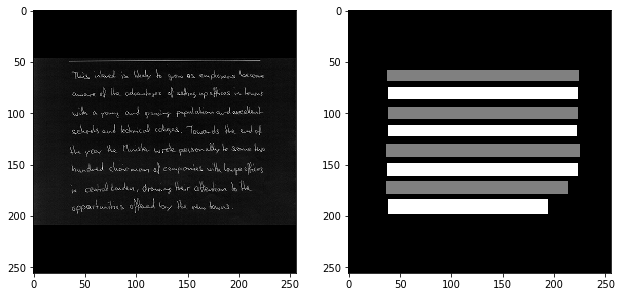

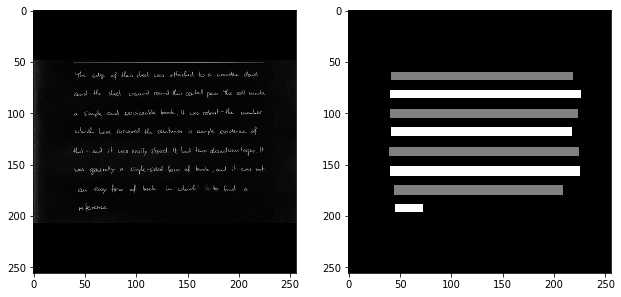

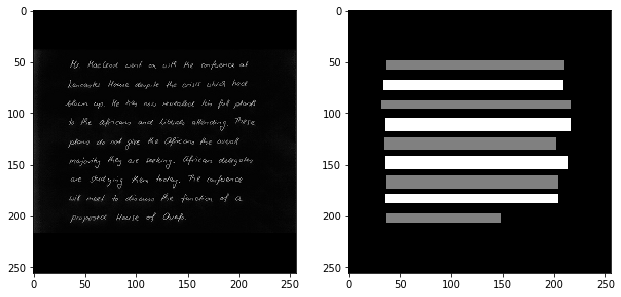

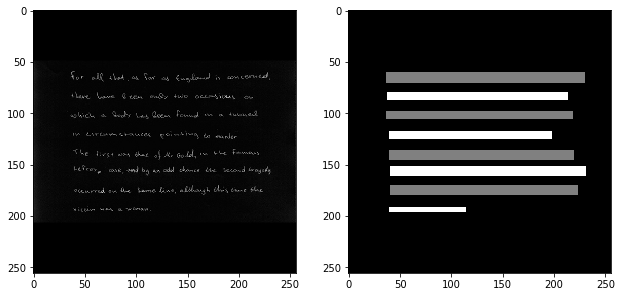

In [4]:
num_plot = 5

for i in np.random.randint(0, dataset.x_train.shape[0], num_plot):
    hplot(dataset.x_train[i], np.argmax(dataset.y_train[i], axis=-1))

In [5]:
MAX_HEIGHT, MAX_WIDTH = dataset.x_train.shape[1:-1]
MAX_HEIGHT, MAX_WIDTH

(256, 256)

In [6]:
base_model_dirname = './_models'
!mkdir -p {base_model_dirname}

identifier = utils.generate_unique_identifier(dirname_with_identifiers=base_model_dirname)

model_dirname = f'{base_model_dirname}/{identifier}'
checkpoints_dirname = f'{model_dirname}/_checkpoints'

!mkdir -p {model_dirname}
!mkdir -p {checkpoints_dirname}

model_dirname

'./_models/5apj4luj'

In [7]:
from typing import Tuple
from tensorflow.keras.utils import Sequence
# import .data_augmentations as augmentations

data_augmentation_params = {
    'width_shift_range': 0.06,
    'height_shift_range': 0.1,
    'horizontal_flip': True,
    'zoom_range': 0.1,
    'fill_mode': 'constant',
    'cval': 0,
    'shear_range': 3,
#     'rotation_range': 2,
#     'vertical_flip': True, - this is a problem for even number of lines.
}


# def random_intensity_transformations(image: np.ndarray) -> np.ndarray:
#     """Randomly apply one of the image intensity transformations on the image."""
#     transformation_functions = [
#         augmentations.noop,
#         augmentations.random_intensity_stretch,
#         augmentations.random_intensity_shrink,
#         augmentations.random_adaptive_histogram_equalization,
#         augmentations.random_gamma_correction,
#         augmentations.random_logarithmic_correction,
#         augmentations.sigmoid_correction,
#     ]
#     function = np.random.choice(transformation_functions)
#     return function(image).astype('float32')


def shuffle(X, Y):
    shuffled_indices = np.random.permutation(X.shape[0])
    return X[shuffled_indices], Y[shuffled_indices]


class DataGenerator(Sequence):
    def __init__(self, X: np.ndarray, Y: np.ndarray, batch_size:int, augment: bool, verbose: bool=False):
        assert X.shape[:-1] == Y.shape[:-1]
        if X.ndim == 4:
            self.X = X
            self.Y = Y
        elif X.ndim == 3:
            self.X = np.expand_dims(X, axis=-1)
            self.Y = np.expand_dims(Y, axis=-1)
        else:
            assert False
        self.batch_size = batch_size
        self.augment = augment
        self.verbose = verbose
        self.num_batches = int(np.ceil(len(X) / self.batch_size))
        self.data_augmentor = ImageDataGenerator(**data_augmentation_params)

    def __log__(self, text: str) -> None:
        if self.verbose:
            print(text)

    def __len__(self) -> int:
        self.__log__(f'Number of batches: {self.num_batches}')
        return self.num_batches

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        self.__log__(f'Enter __getitem__() idx: {idx}')
        X_batch = self.X[idx * self.batch_size:(idx + 1) * self.batch_size].copy()
        Y_batch = self.Y[idx * self.batch_size:(idx + 1) * self.batch_size].copy()

        if self.augment:
            X_batch, Y_batch = self.augment_data(X_batch, Y_batch)
            X_batch, Y_batch = shuffle(X_batch, Y_batch)
            assert len(np.unique(Y_batch)) == 2

        self.__log__(f'Exit __getitem__() idx: {idx}, X: {X_batch.shape}, Y: {Y_batch.shape}')
        return X_batch, Y_batch

    def augment_data(self, X, Y):
        X_aug, Y_aug = zip(*[self._augment_data(x, y) for x, y in zip(X, Y)])
        return np.stack(X_aug, axis=0), np.stack(Y_aug, axis=0)

    def _augment_data(self, x, y):
        transform_parameters = self.data_augmentor.get_random_transform(x.shape)
        x_aug = self.data_augmentor.apply_transform(x, transform_parameters)
        y_aug = self.data_augmentor.apply_transform(y, transform_parameters)
#         x_aug = random_intensity_transformations(x_aug)
        return x_aug, y_aug
    
    def on_epoch_end(self) -> None:
        """
        Shuffle all submissions in the dataframe so that the model does not see the same set of submissions
        (shuffled or not) in a step of any epoch.
        """
        self.X, self.Y = shuffle(self.X, self.Y)

### Test data generator

In [8]:
train_dg = DataGenerator(X=dataset.x_train, Y=dataset.y_train, batch_size=5, augment=True)
train_dg.__len__()

246

In [9]:
X, Y = train_dg.__getitem__(3)
X.shape, Y.shape

((5, 256, 256, 1), (5, 256, 256, 3))

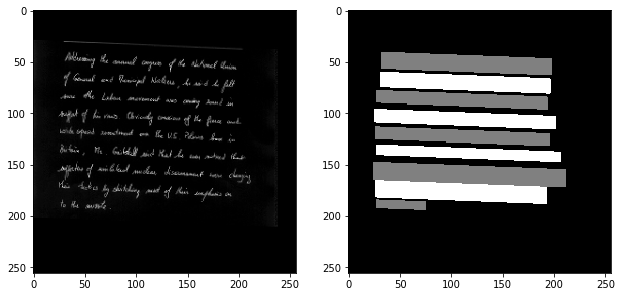

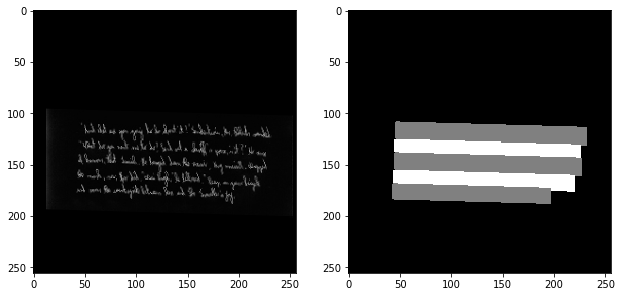

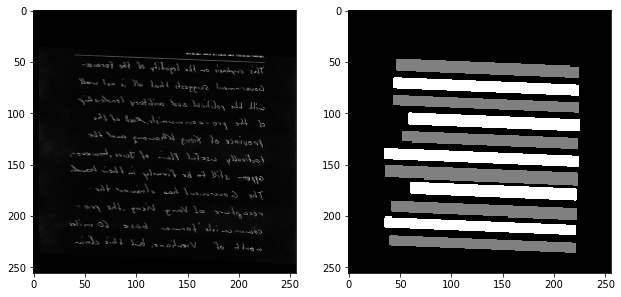

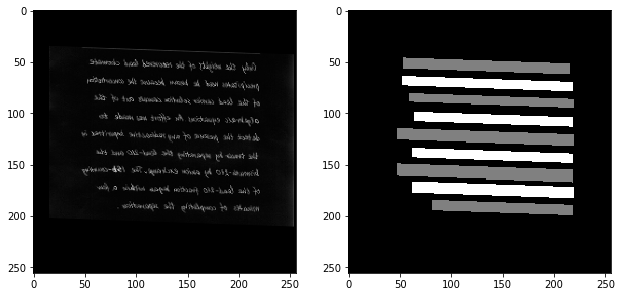

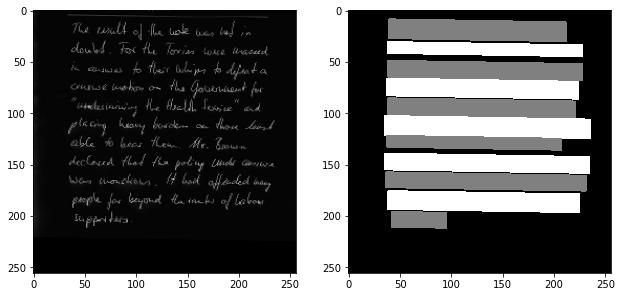

In [10]:
for i in range(5):
    hplot(X[i], np.argmax(Y[i], axis=-1))

## Model

In [14]:
from typing import List

K.clear_session()  

def residual_conv_block(input_layer: Layer,
                        kernel_sizes: List[int],
                        num_filters: List[int],
                        dilation_rates: List[int],
                        act: str) -> Layer:
    """Method to instantiate a Residual convolutional block."""
    assert len(num_filters) == 2

    padding = 'same'
    x = Conv2D(num_filters[0], kernel_size=kernel_sizes[0], dilation_rate=dilation_rates[0], 
               padding=padding, activation=act)(input_layer)
    x = Conv2D(num_filters[1], kernel_size=kernel_sizes[1], dilation_rate=dilation_rates[1], padding=padding)(x)
    y = Conv2D(num_filters[1], kernel_size=1, dilation_rate=1, padding=padding)(input_layer)
    x = Add()([x, y])
    x = Activation(act)(x)
    return x

num_filters = [16] * 14
kernel_sizes = [7] * 14
dilation_rates = [3] * 4 + [7] * 10

input_image = Input((MAX_HEIGHT, MAX_WIDTH, 1))

model_layer = input_image
for i in range(0, len(num_filters), 2):
    model_layer = residual_conv_block(input_layer=model_layer, 
                                      kernel_sizes=kernel_sizes[i:i+2], 
                                      num_filters=num_filters[i:i+2], 
                                      dilation_rates=dilation_rates[i:i+2], 
                                      act='relu')
output = Conv2D(dataset.num_classes, kernel_size=1, dilation_rate=1, padding='same', activation='softmax')(model_layer)

model = Model(inputs=input_image, outputs=output)
model.compile(optimizer=Adam(0.001/2), loss='categorical_crossentropy')    
model.summary()

    
callbacks = [
    EarlyStopping(monitor='val_loss', patience=35),
    ModelCheckpoint(
            filepath=checkpoints_dirname + "/epoch_{epoch:02d}-val_loss_{val_loss:.4f}.h5",
            monitor='val_loss',
            save_best_only=True
        )
]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 800         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 12560       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 32          input_1[0][0]                    
__________________________________________________________________________________________________
add (Add) 

In [ ]:
%%time 

batch_size = 32
train_dg = DataGenerator(X=dataset.x_train, Y=dataset.y_train, batch_size=batch_size, augment=True)

history = model.fit_generator(
    generator=train_dg, 
    epochs=1000,
    validation_data=(dataset.x_test, dataset.y_test),
    shuffle=True,
    callbacks=callbacks    
)

Epoch 1/1000
39/39 [==============================] - 35s 887ms/step - loss: 22.7099 - val_loss: 15.6361
Epoch 2/1000
39/39 [==============================] - 32s 820ms/step - loss: 15.5553 - val_loss: 13.9937
Epoch 3/1000
39/39 [==============================] - 32s 826ms/step - loss: 14.3950 - val_loss: 12.8460
Epoch 4/1000
39/39 [==============================] - 32s 832ms/step - loss: 13.2623 - val_loss: 11.5656
Epoch 5/1000
39/39 [==============================] - 33s 838ms/step - loss: 11.0028 - val_loss: 8.2486
Epoch 6/1000
39/39 [==============================] - 33s 838ms/step - loss: 8.6243 - val_loss: 8.2744
Epoch 7/1000
39/39 [==============================] - 33s 840ms/step - loss: 7.1836 - val_loss: 6.8938
Epoch 8/1000
39/39 [==============================] - 33s 839ms/step - loss: 6.7515 - val_loss: 6.8069
Epoch 9/1000
39/39 [==============================] - 33s 844ms/step - loss: 6.5973 - val_loss: 6.1652
Epoch 10/1000
39/39 [==============================] - 33s 837ms

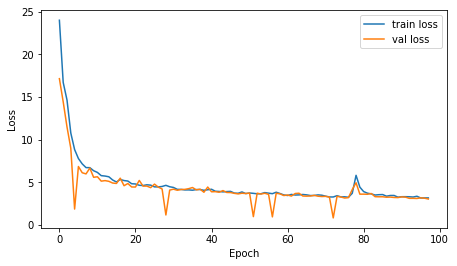

In [20]:
utils.plot_training_history(history.history, metric=None)

## Loading best model

In [21]:
model_filenames = !ls {checkpoints_dirname} -t
best_model_filename = model_filenames[0]

!cp {checkpoints_dirname}/{best_model_filename} {model_dirname}
!rm {checkpoints_dirname}/*
best_model_filename

'epoch_73-val_loss_0.8193.h5'

In [16]:
best_model_filename = 'epoch_73-val_loss_0.8193.h5'

In [17]:
model.load_weights(f'{model_dirname}/{best_model_filename}')
best_model_filename

'epoch_73-val_loss_0.8193.h5'

## Model evaluation

In [18]:
if FLATTEN_TARGET:
    target = Y_test.reshape(Y_test.shape[0], -1)
else:
    target = Y_test
    
model.evaluate(X_test, target, batch_size=batch_size)

537/537 [==============================] - 7s 14ms/step


3.243524725876707

In [21]:
## debug
x = X_test[0]
y = Y_test[0]
x.shape, y.shape

((316, 310, 1), (316, 310, 3))

In [23]:
model.evaluate(np.expand_dims(x, axis=0), np.expand_dims(y, axis=0))

1/1 [==============================] - 0s 56ms/step


0.06578128039836884

In [24]:
y_pred = model.predict(np.expand_dims(x, axis=0))[0]
y_pred.shape

(316, 310, 3)

In [27]:
np.unique(np.round(np.sum(y_pred, axis=-1), 2))  # softmax is the right thing to do!

array([1.], dtype=float32)

In [41]:
loss = y * np.log(y_pred)
sum([loss[:,:,i].mean() for i in range(loss.shape[-1])]), loss.mean() * 3

(-0.06578128086403012, -0.06578127667307854)

In [45]:
K.eval(K.categorical_crossentropy(target=y, output=y_pred)).mean()

0.06578128

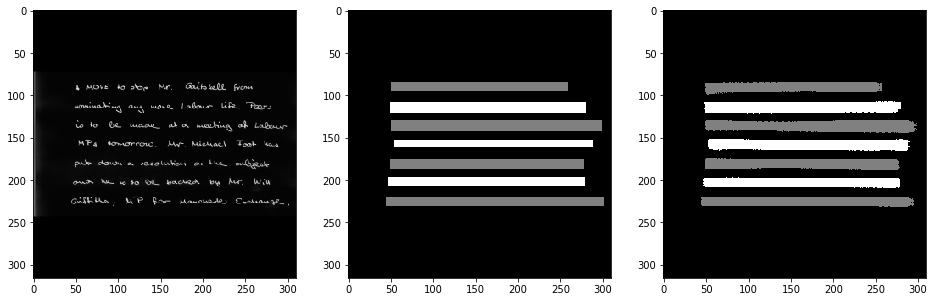

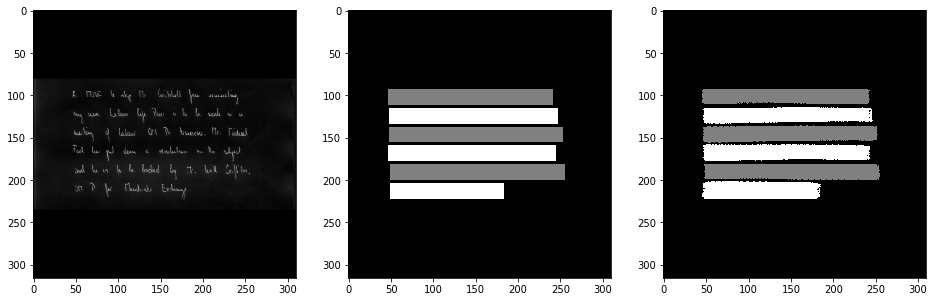

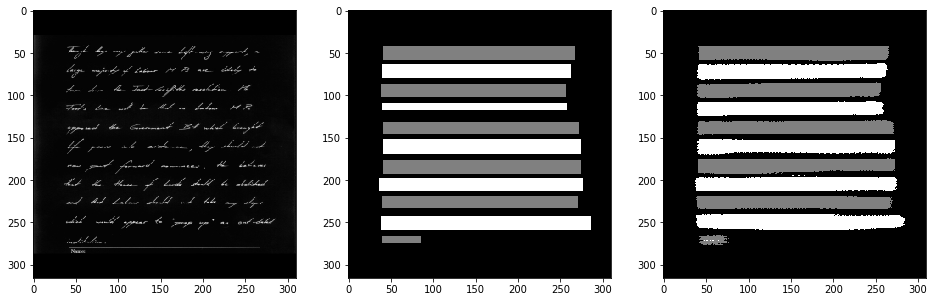

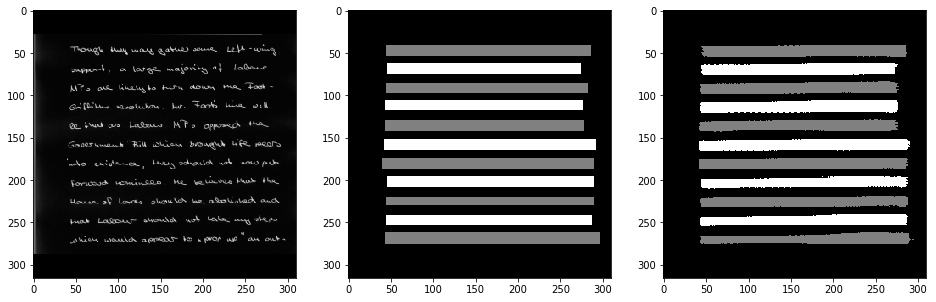

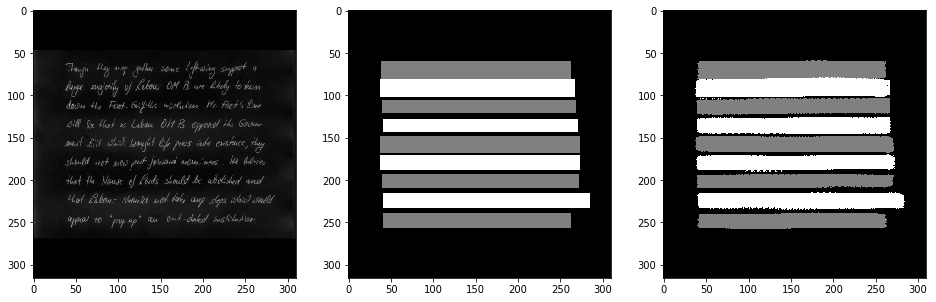

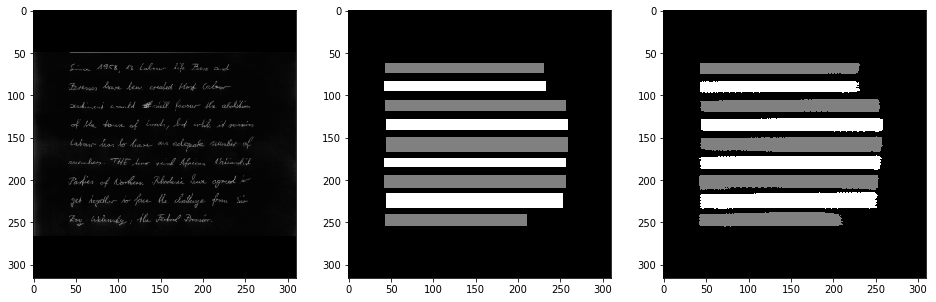

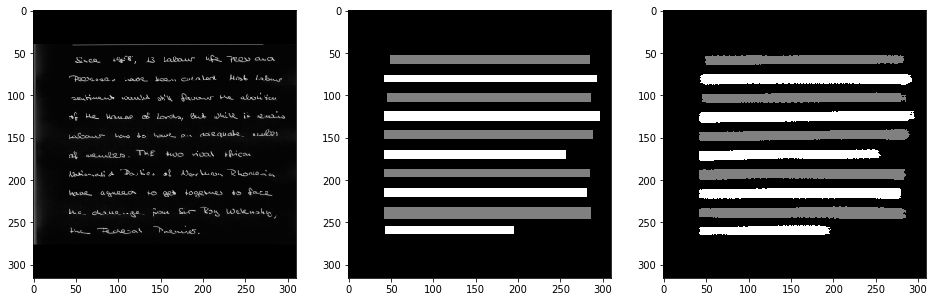

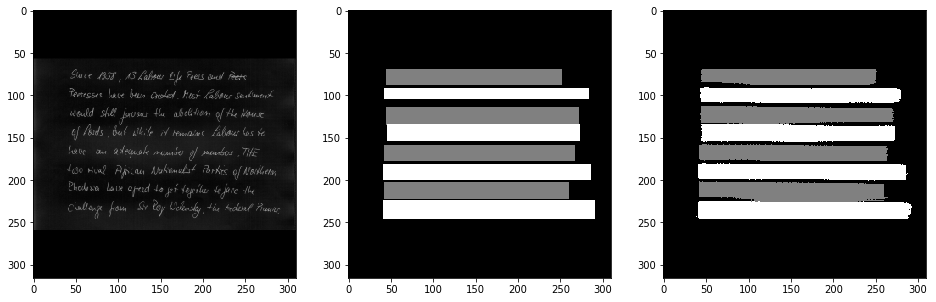

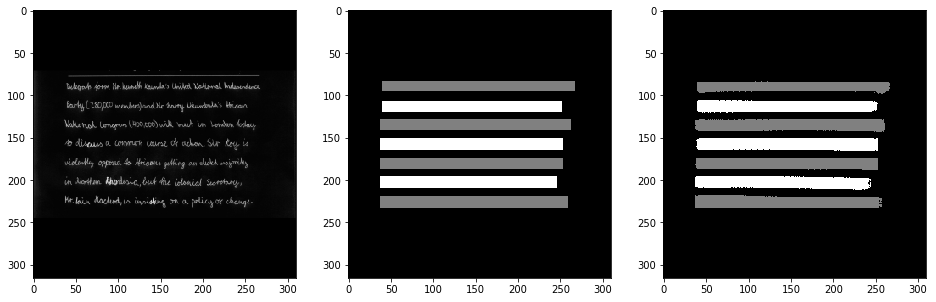

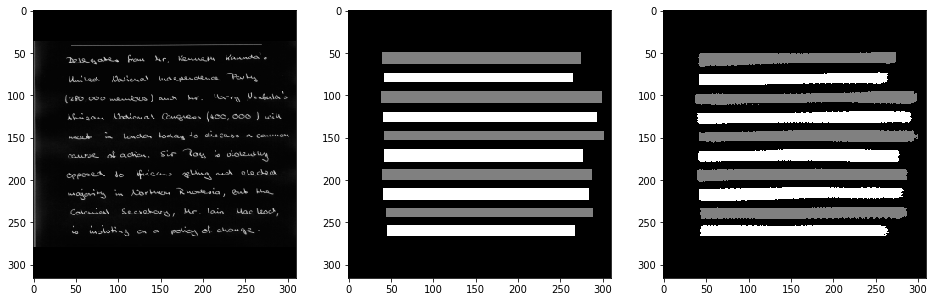

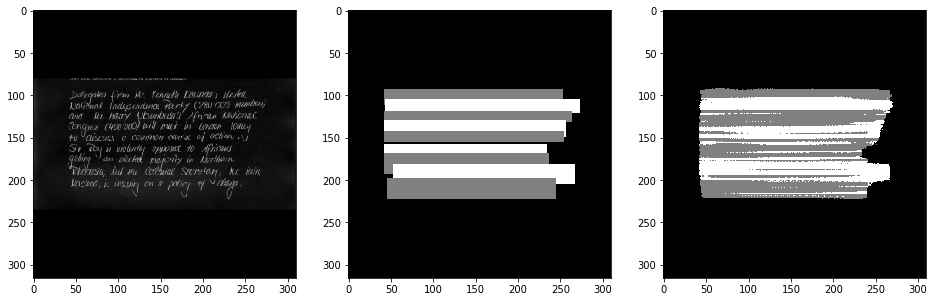

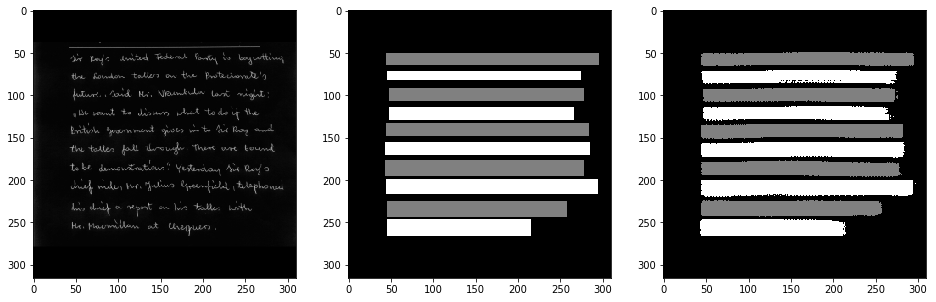

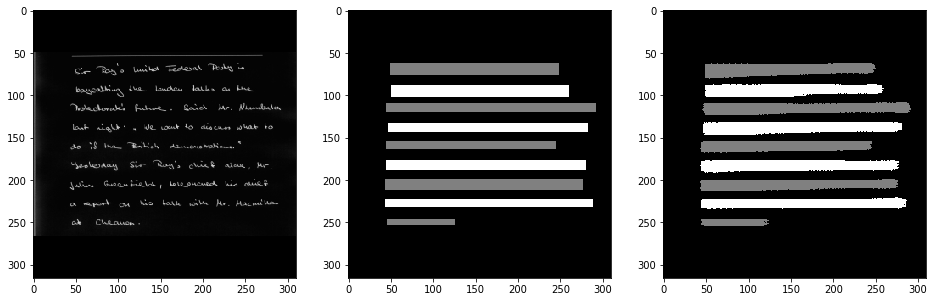

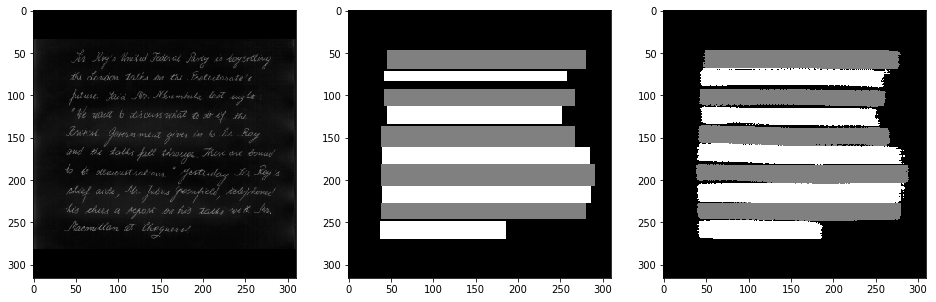

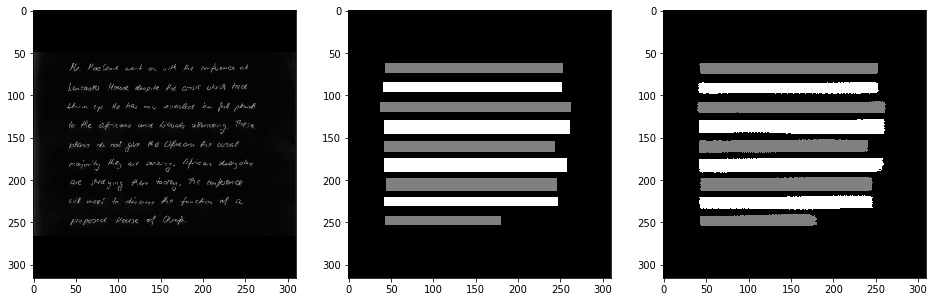

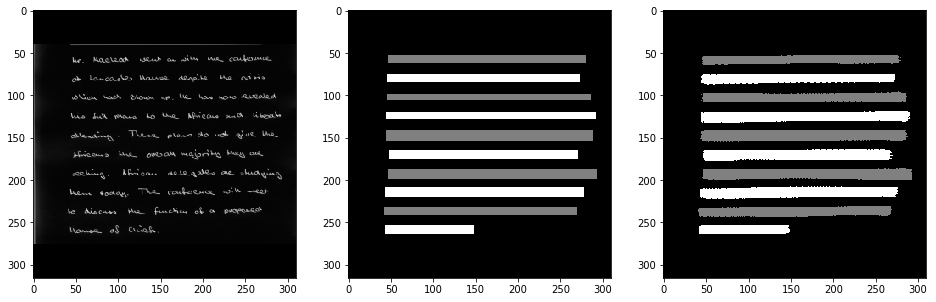

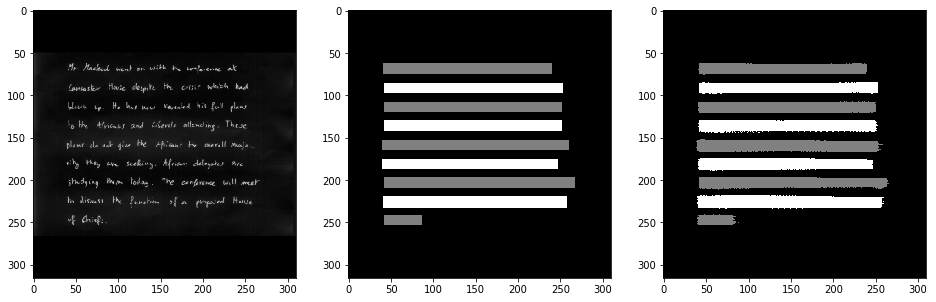

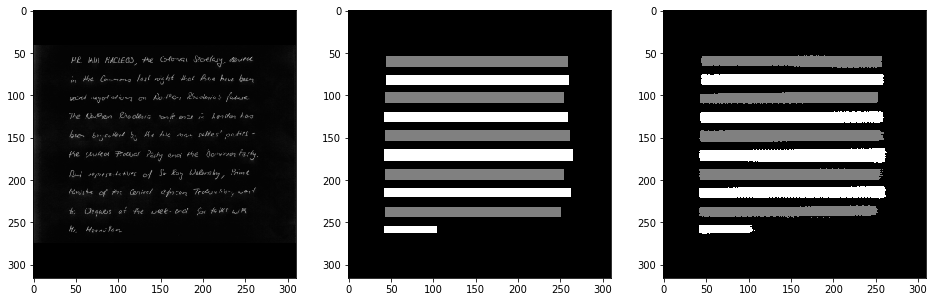

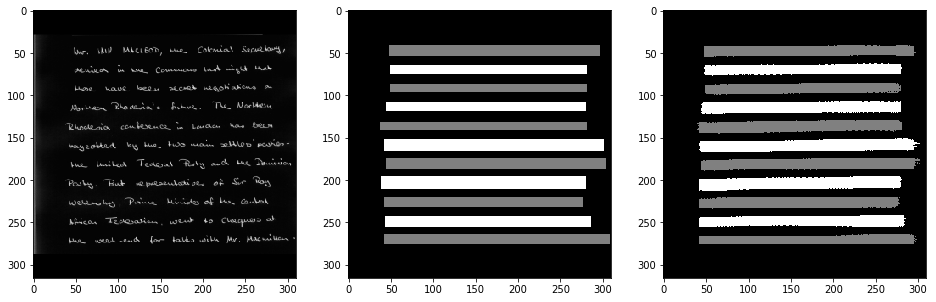

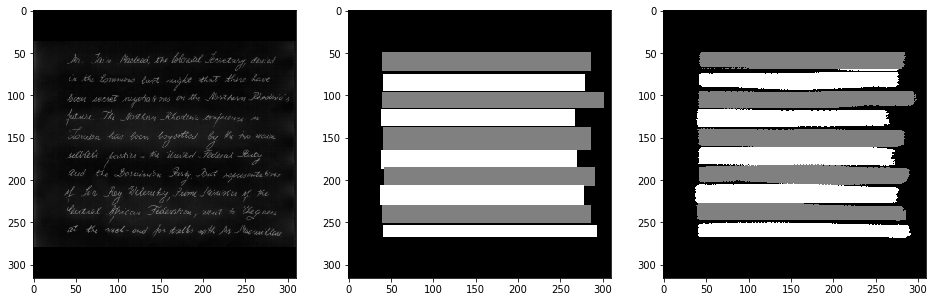

In [24]:
start_id = 0
count = 20

X = X_train[start_id:start_id+count]
Y = Y_train[start_id:start_id+count]

Y_pred = model.predict(X)
for x, y, y_pred in zip(X, Y, Y_pred):
    if not PREDICT_ALTERNATING_LINES:
        hplot(x, y, y_pred)
    else:
        hplot(x, np.argmax(y, axis=-1), np.argmax(y_pred, axis=-1))

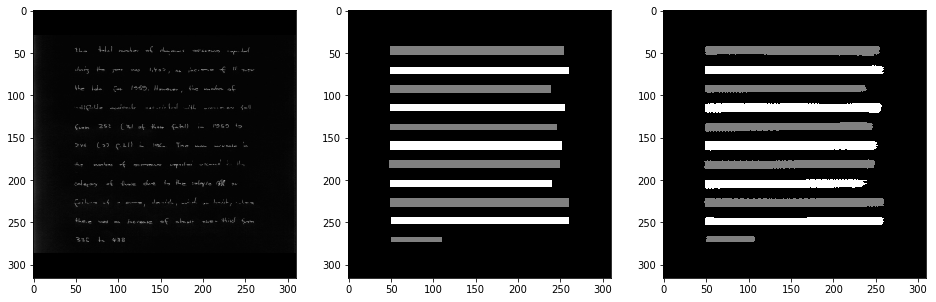

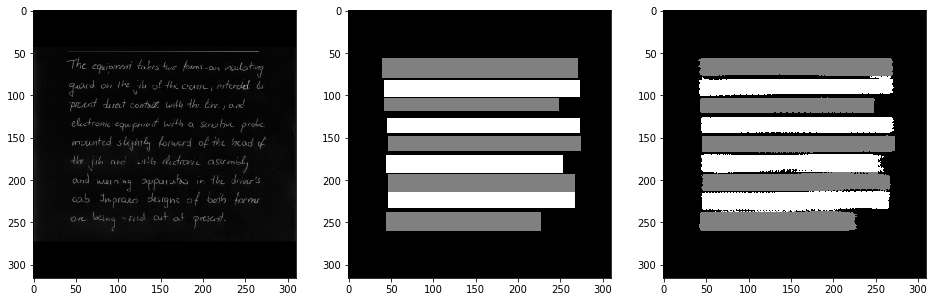

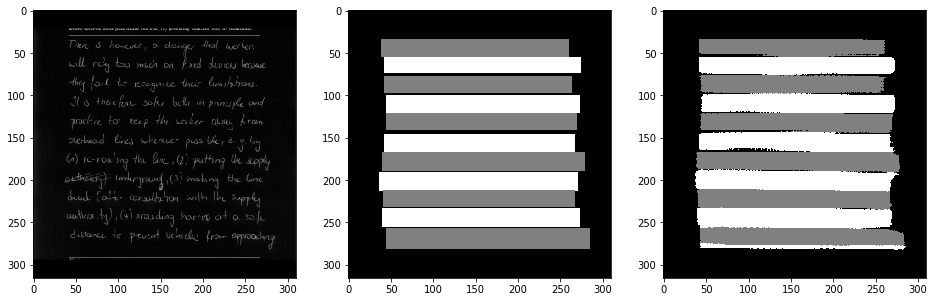

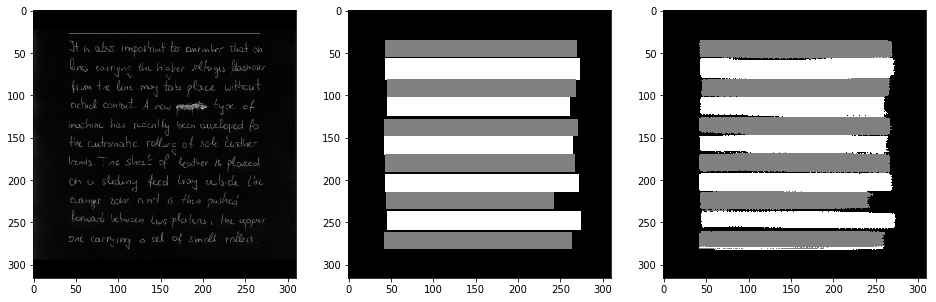

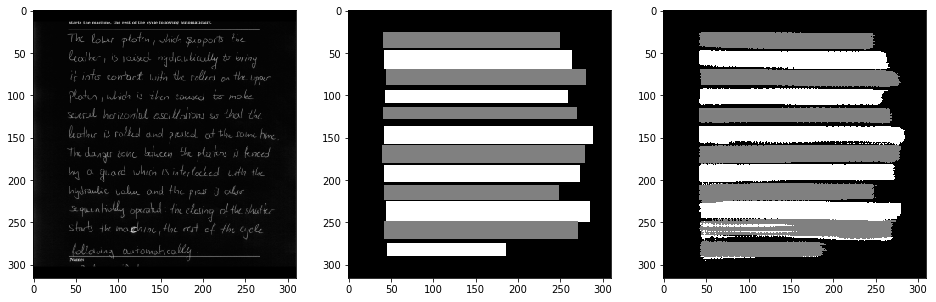

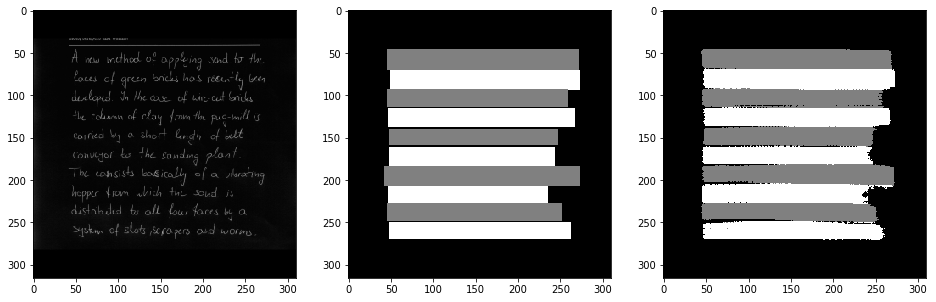

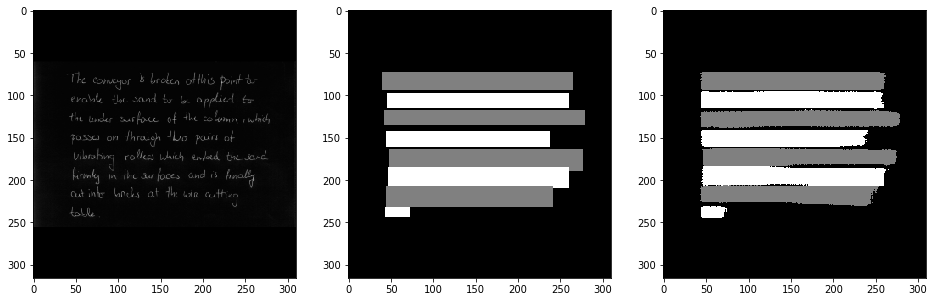

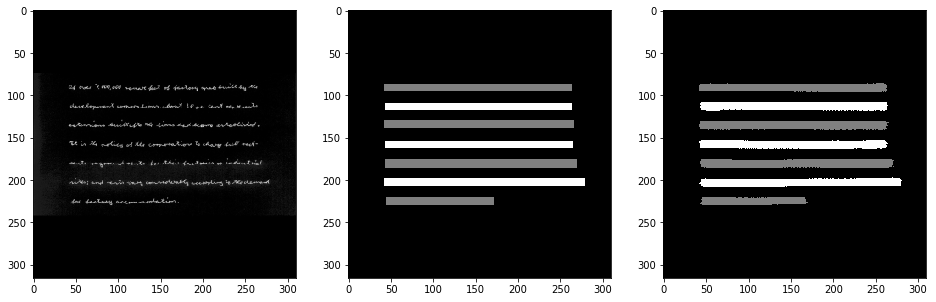

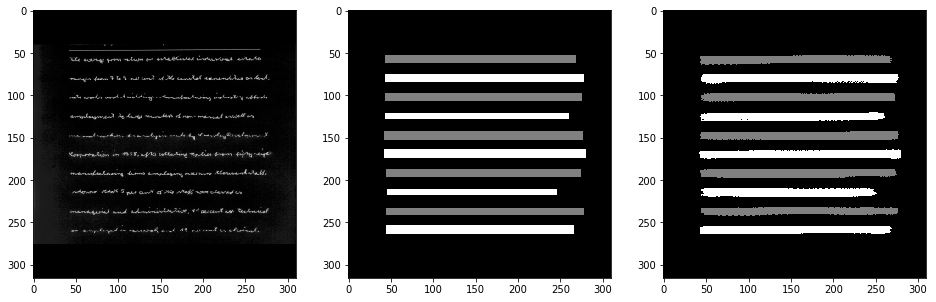

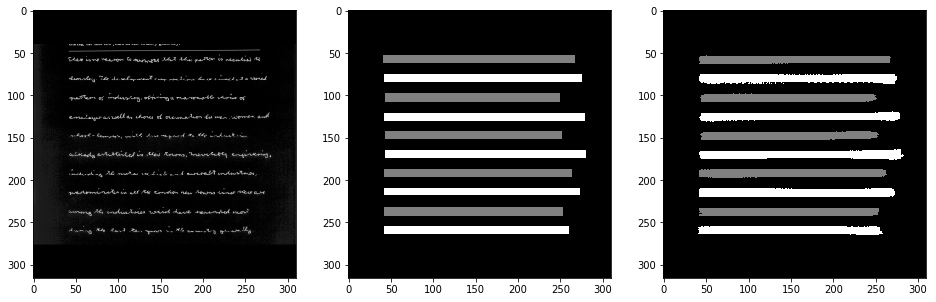

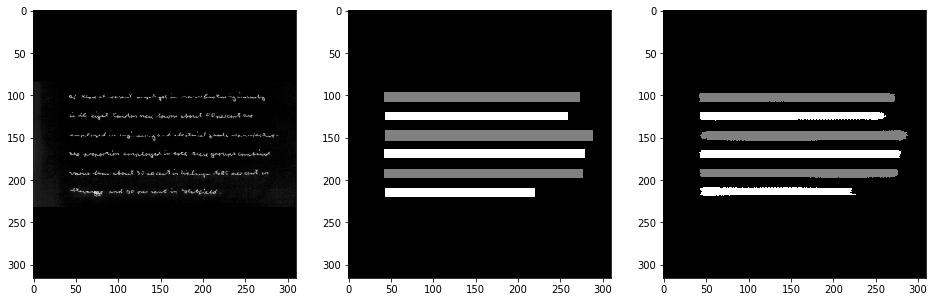

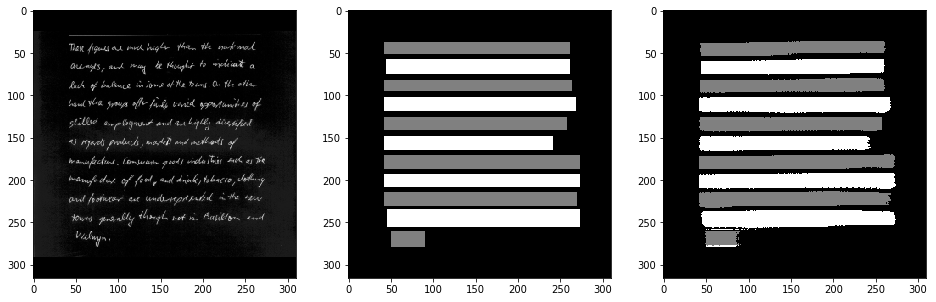

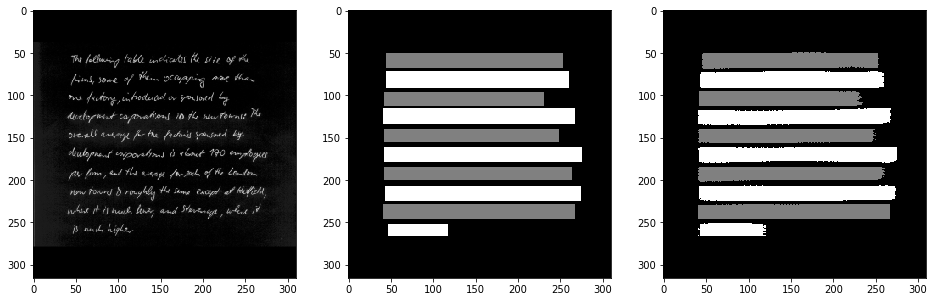

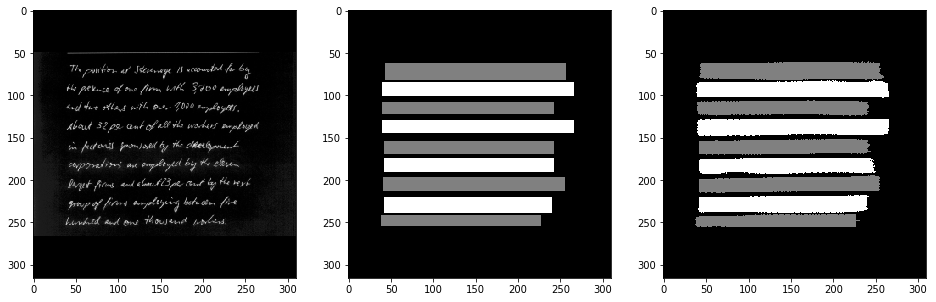

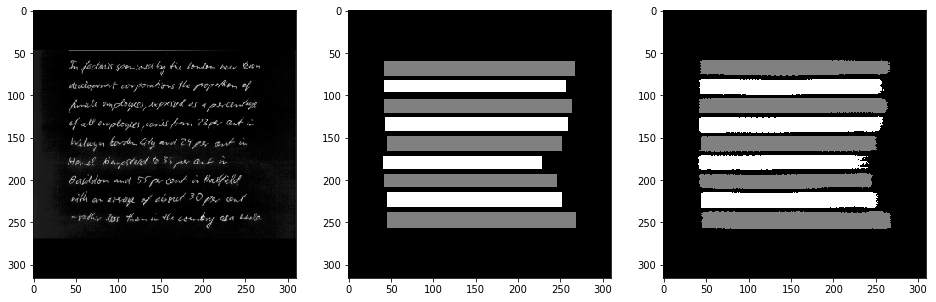

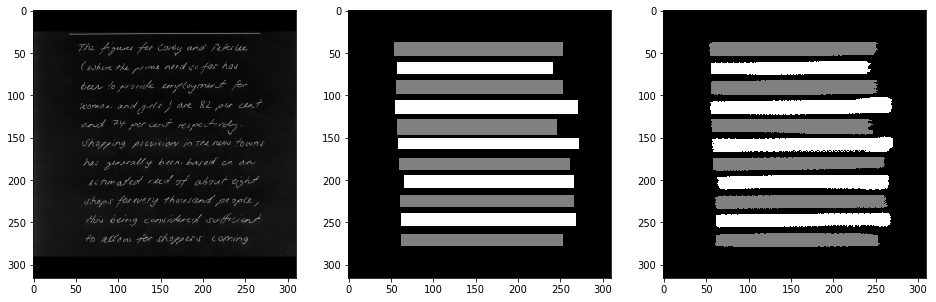

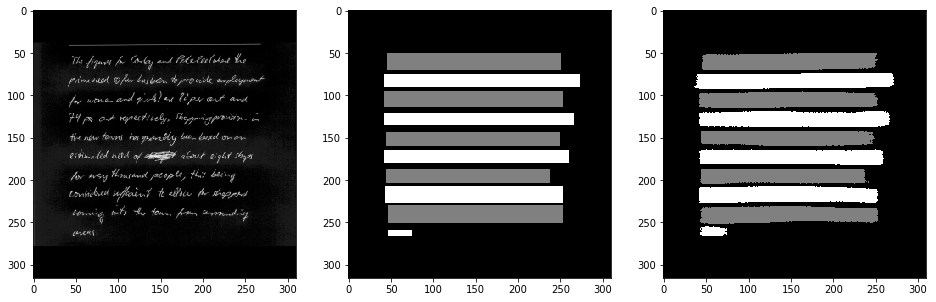

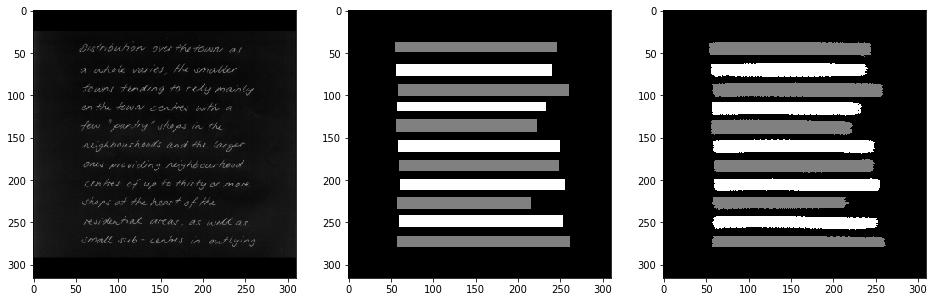

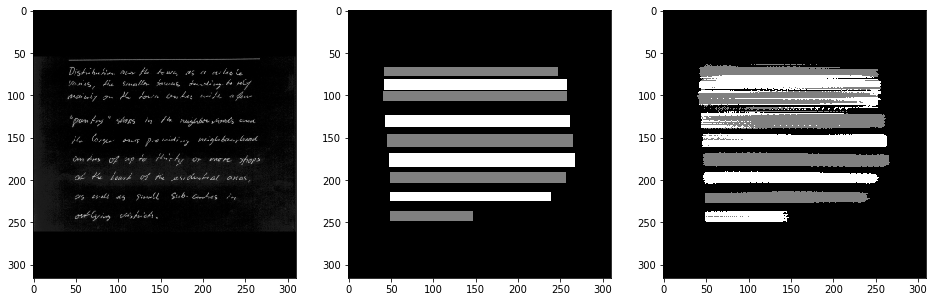

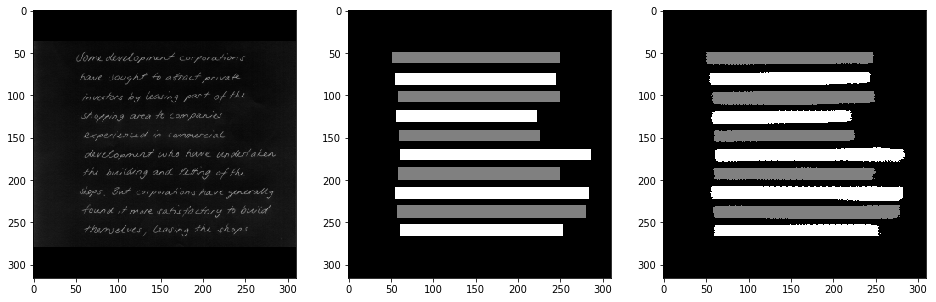

In [25]:
start_id = 0
count = 20

X = X_test[start_id:start_id+count]
Y = Y_test[start_id:start_id+count]

Y_pred = model.predict(X)
for x, y, y_pred in zip(X, Y, Y_pred):
    if not PREDICT_ALTERNATING_LINES:
        hplot(x, y, y_pred)
    else:
        hplot(x, np.argmax(y, axis=-1), np.argmax(y_pred, axis=-1))